# Analysis of Airbnb data from my home town Munich using the CRISP-DM process

## Step 1: Business Understanding 
In this notebook following questions will be invetigated:

- How does the average rental price for Airbnb offers in Munich develop over the year, using 2022/2023 as an example?
- How does the listing price differ across neighborhoods. What are the most expensive and what are the most affordable locations?
- Can the listing price be predicted based on certain characteristics?

## Step 2: Data Understanding
To answer the business questions the Airbnb data from insideairbnb for Munich is used. There are 2 datasets availiable that can help to answer the questions:
- The listings for Munich: (http://data.insideairbnb.com/germany/bv/munich/2022-09-21/data/listings.csv.gz)
- The booking calander for Munich: http://data.insideairbnb.com/germany/bv/munich/2022-09-21/data/calendar.csv.gz

There is also a decribtion of the columns for the listings file availiable under https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?usp=sharing , that is used for a better understanding of the listings columns

Due to the data in the above files is a spotlight for the actual date the files where downloaded locallly to get results that can be reprocuded at a later time.

In [64]:
# import needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
import scipy as sp
%matplotlib inline

#load the dataset of munich airbnb listings and the calendar
df_listmuc = pd.read_csv('listings_munich.csv')
df_calmuc = pd.read_csv('calendar_munich.csv')

##### Listing dataset df_listmuc

In [65]:
#size of the listing datatset
print('The listing dataset contains',df_listmuc.shape[0],'rows and',df_listmuc.shape[1],'index')

The listing dataset contains 6627 rows and 75 index


In [66]:
#Get the data types and their frequencies of the listings
print('Datatypes and their frequency of the listing dataset:')
df_listmuc.dtypes.value_counts()

Datatypes and their frequency of the listing dataset:


object     35
int64      23
float64    17
dtype: int64

In [67]:
#get detailed information of the listing dataset
print('index of the listing dataset, NaNs and datatypes of the index:')
df_listmuc.info()


index of the listing dataset, NaNs and datatypes of the index:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6627 entries, 0 to 6626
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6627 non-null   int64  
 1   listing_url                                   6627 non-null   object 
 2   scrape_id                                     6627 non-null   int64  
 3   last_scraped                                  6627 non-null   object 
 4   source                                        6627 non-null   object 
 5   name                                          6627 non-null   object 
 6   description                                   6470 non-null   object 
 7   neighborhood_overview                         3028 non-null   object 
 8   picture_url                                   6627 non-null   object 
 9   

##### Calendar dataset df_calmuc

In [68]:
#size of the listing datatset
print('The calendar dataset contains',df_calmuc.shape[0],'rows and',df_calmuc.shape[1],'index')

The calendar dataset contains 2418520 rows and 7 columns


In [69]:
#Get the data types and their frequencies of the calendar
print('Datatypes and their frequency of the calendar dataset:')
df_calmuc.dtypes.value_counts()

Datatypes and their frequency of the calendar dataset:


object     4
float64    2
int64      1
dtype: int64

In [70]:
#get detailed information of the calendar dataset
print('Columns of the calendar dataset, NaNs and datatypes of the columns:')
df_calmuc.info()

Columns of the calendar dataset, NaNs and datatypes of the columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2418520 entries, 0 to 2418519
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 129.2+ MB


In [71]:
# Which columns had no missing values?
no_nulls=set(df_calmuc.columns[df_calmuc.isnull().mean()==0])
print('columns with no nulls:',no_nulls)

columns with no nulls: {'available', 'price', 'listing_id', 'adjusted_price', 'date'}


## Step 3: Data Preparation
Wrangle and clean the datasets

##### df_listmuc:

In [72]:
# convert the price column from string to number => function is also needed for df_calmuc
def convert_price(df):
    #delete the leading $ sign
    df.price = df.price.str[1:]
    #delete the "," in the price string
    df.price = df.price.str.replace(',','')
    #convert string to float
    df.price = df.price.astype(float)
    return


In [73]:
#Copy the columns of interest for the third business question in an extra dataset.
#The first thought was that the features from the amenities column might be interesting for determining the price. 
#However, a manual examination of the data showed that they are very unordered and there is no consistent structure behind them. 
#Using the data from this column would only be possible with a very large effort. 
# Therefore, the focus is on the other properties stored in the listing file to determine the price.

#Filtering the columns of interest for the price prediction

col_of_interest = [
    'id',
    'host_has_profile_pic',
    'host_identity_verified',
    'neighbourhood_cleansed',
    'host_response_time',
    'host_response_rate',
    'host_acceptance_rate',
    'host_is_superhost',
    'room_type',
    'accommodates',
    'bathrooms',
    'bathrooms_text',
    'bedrooms',
    'beds',
    'price',
    'minimum_nights',
    'maximum_nights',
   	'number_of_reviews',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
]

df_listmuc_int = df_listmuc[col_of_interest].copy()
df_listmuc_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6627 entries, 0 to 6626
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6627 non-null   int64  
 1   host_has_profile_pic         6627 non-null   object 
 2   host_identity_verified       6627 non-null   object 
 3   neighbourhood_cleansed       6627 non-null   object 
 4   host_response_time           5133 non-null   object 
 5   host_response_rate           5133 non-null   object 
 6   host_acceptance_rate         5482 non-null   object 
 7   host_is_superhost            6627 non-null   object 
 8   room_type                    6627 non-null   object 
 9   accommodates                 6627 non-null   int64  
 10  bathrooms                    0 non-null      float64
 11  bathrooms_text               6617 non-null   object 
 12  bedrooms                     6100 non-null   float64
 13  beds              

In [74]:
#drop row with NaN for columns with over 6000 non nulls
df_listmuc_int.dropna(subset=['bathrooms_text', 'bedrooms','beds'], inplace = True)

In [75]:
#convert the price column to numeric format
convert_price(df_listmuc_int)

In [76]:
#convert the percentage string to number
df_listmuc_int['host_acceptance_rate'] = df_listmuc_int['host_acceptance_rate'].str.rstrip("%")
df_listmuc_int['host_response_rate'] = df_listmuc_int['host_response_rate'].str.rstrip('%')
df_listmuc_int.host_acceptance_rate = df_listmuc_int.host_acceptance_rate.astype(float)
df_listmuc_int.host_response_rate = df_listmuc_int.host_response_rate.astype(float)
df_listmuc_int.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 1 to 6626
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6000 non-null   int64  
 1   host_has_profile_pic         6000 non-null   object 
 2   host_identity_verified       6000 non-null   object 
 3   neighbourhood_cleansed       6000 non-null   object 
 4   host_response_time           4708 non-null   object 
 5   host_response_rate           4708 non-null   float64
 6   host_acceptance_rate         5020 non-null   float64
 7   host_is_superhost            6000 non-null   object 
 8   room_type                    6000 non-null   object 
 9   accommodates                 6000 non-null   int64  
 10  bathrooms                    0 non-null      float64
 11  bathrooms_text               6000 non-null   object 
 12  bedrooms                     6000 non-null   float64
 13  beds              

In [77]:
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
 
df_listmuc_int.host_response_rate = imputer.fit_transform(df_listmuc_int['host_response_rate'].values.reshape(-1,1))[:,0]
df_listmuc_int.host_acceptance_rate = imputer.fit_transform(df_listmuc_int['host_acceptance_rate'].values.reshape(-1,1))[:,0]
imputer = SimpleImputer(missing_values=np.NaN, strategy = 'most_frequent')
df_listmuc_int.host_response_time = imputer.fit_transform(df_listmuc_int['host_response_time'].values.reshape(-1,1))[:,0]

In [78]:
#get the number of baths from bathrooms_text
df_listmuc_int['bathrooms'] = df_listmuc_int.bathrooms_text.str.extract('([-+]?\d*\.?\d+)')
df_listmuc_int.dropna(subset=['bathrooms'], inplace = True)
df_listmuc_int.bathrooms = df_listmuc_int.bathrooms.astype('float')
df_listmuc_int.drop('bathrooms_text', axis = 1, inplace=True)
df_listmuc_int.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5980 entries, 1 to 6626
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           5980 non-null   int64  
 1   host_has_profile_pic         5980 non-null   object 
 2   host_identity_verified       5980 non-null   object 
 3   neighbourhood_cleansed       5980 non-null   object 
 4   host_response_time           5980 non-null   object 
 5   host_response_rate           5980 non-null   float64
 6   host_acceptance_rate         5980 non-null   float64
 7   host_is_superhost            5980 non-null   object 
 8   room_type                    5980 non-null   object 
 9   accommodates                 5980 non-null   int64  
 10  bathrooms                    5980 non-null   float64
 11  bedrooms                     5980 non-null   float64
 12  beds                         5980 non-null   float64
 13  price             

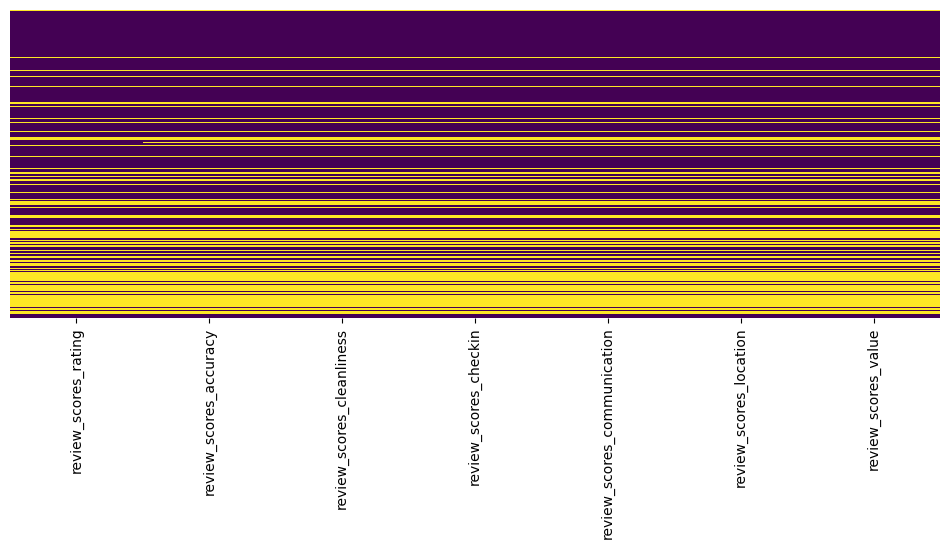

In [79]:
#check the NaN with graphic
cols = [
    'review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
    'review_scores_communication','review_scores_location','review_scores_value'
        ]
sns.heatmap(df_listmuc_int[cols].isnull(),yticklabels=False,cbar=False,cmap='viridis');

In [80]:
#fill the NaN with the mean
df_listmuc_int[cols] = df_listmuc_int[cols].fillna(df_listmuc_int[cols].mean())

In [81]:
#convert the index with t and f to bool with true or false
d = {'t': True, 'f': False}

df_listmuc_int['host_has_profile_pic'].replace(d, inplace=True)
df_listmuc_int['host_identity_verified'].replace(d, inplace = True)
df_listmuc_int['host_is_superhost'].replace(d, inplace = True)
df_listmuc_int.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5980 entries, 1 to 6626
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           5980 non-null   int64  
 1   host_has_profile_pic         5980 non-null   bool   
 2   host_identity_verified       5980 non-null   bool   
 3   neighbourhood_cleansed       5980 non-null   object 
 4   host_response_time           5980 non-null   object 
 5   host_response_rate           5980 non-null   float64
 6   host_acceptance_rate         5980 non-null   float64
 7   host_is_superhost            5980 non-null   bool   
 8   room_type                    5980 non-null   object 
 9   accommodates                 5980 non-null   int64  
 10  bathrooms                    5980 non-null   float64
 11  bedrooms                     5980 non-null   float64
 12  beds                         5980 non-null   float64
 13  price             

/var/folders/0h/xbxnbrh51_1404x1c12g36b80000gn/T/ipykernel_11922/3915035698.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_listmuc_int.hist(ax=ax);


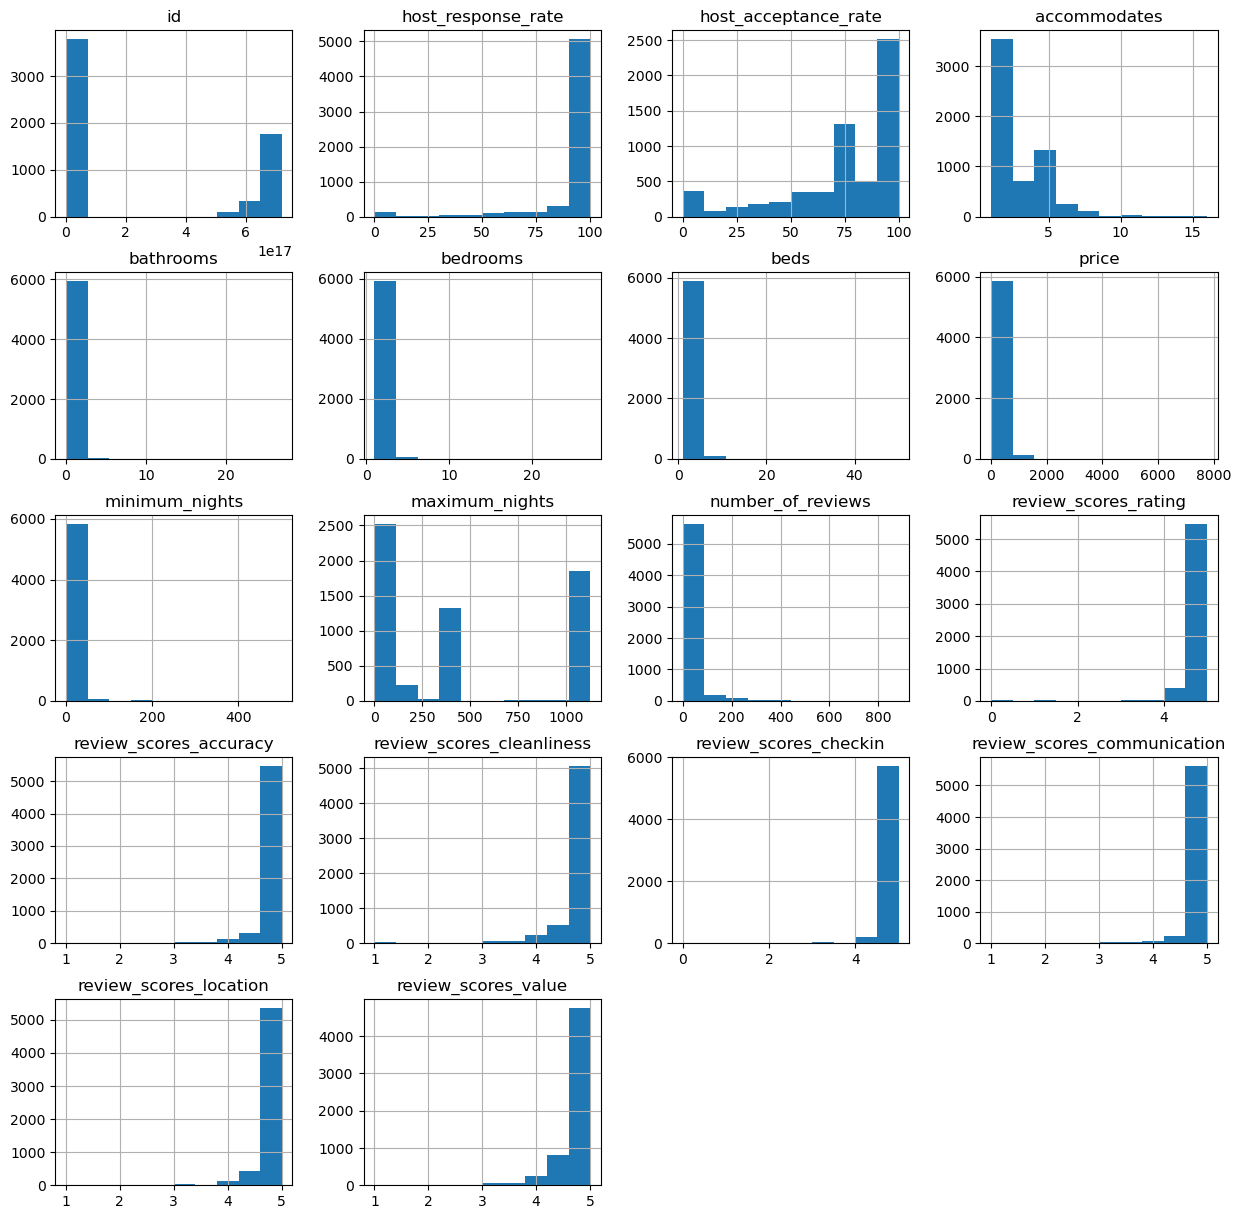

In [82]:
#graphical overview
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
df_listmuc_int.hist(ax=ax);

/var/folders/0h/xbxnbrh51_1404x1c12g36b80000gn/T/ipykernel_11922/1311424423.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(df_listmuc_int.corr(), annot=True, fmt=".2f");


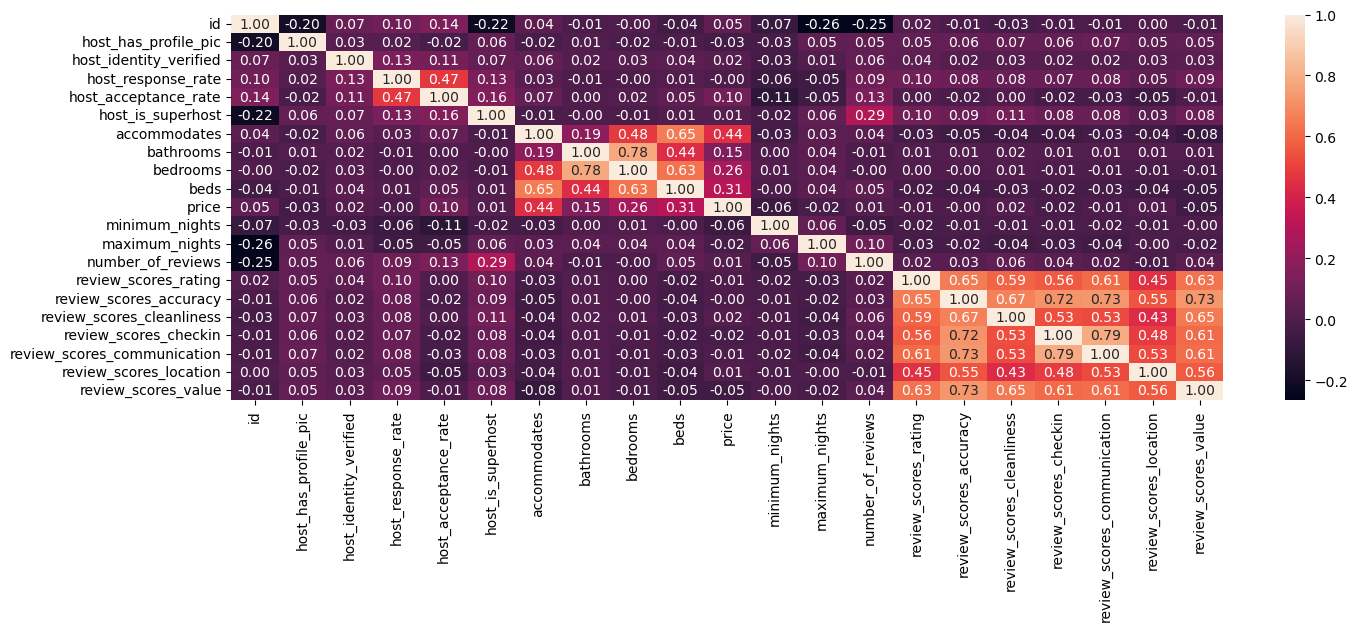

In [83]:
plt.figure(figsize = (16,5))
ax = sns.heatmap(df_listmuc_int.corr(), annot=True, fmt=".2f");

##### df_calmuc:

In [84]:
# convert the price column from string to number
convert_price(df_calmuc)

In [85]:
#convert the date column from string to datetime format
df_calmuc.date = pd.to_datetime(df_calmuc.date)

In [86]:
#add a column with the weekdays, see https://stackoverflow.com/questions/28009370/get-weekday-day-of-week-for-datetime-column-of-dataframe
df_calmuc['weekday_num']= df_calmuc['date'].apply(lambda x: x.weekday())
#filter the day(s) of the weekend, here Friday and Saturday to see if these are high price days
df_weekend = df_calmuc[df_calmuc.weekday_num.isin([4])]
#add a column with the month
df_calmuc['month'] = df_calmuc['date'].apply(lambda x: x.month)
#replace the number of the month with the name
df_calmuc['month'] = pd.to_datetime(df_calmuc['month'], format='%m').dt.month_name().str[:3]
#replace the number of the weekday with the name
df_calmuc['weekday'] = pd.to_datetime(df_calmuc['date'], format='%m').dt.day_name()

In [87]:
#get the number of missing values
print('missing values:',df_calmuc.isnull().sum())
#drop the rows with missing values
df_calmuc = df_calmuc.dropna()


missing values: listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    1
maximum_nights    1
weekday_num       0
month             0
weekday           0
dtype: int64


## Step 4: Data Modeling

To answer question 1 "How does the average rental price for Airbnb offers in Munich develop over the year, using 2022/2023 as an example?" the calendar dataset is used and the devlopment of the mean price over the year plotted.

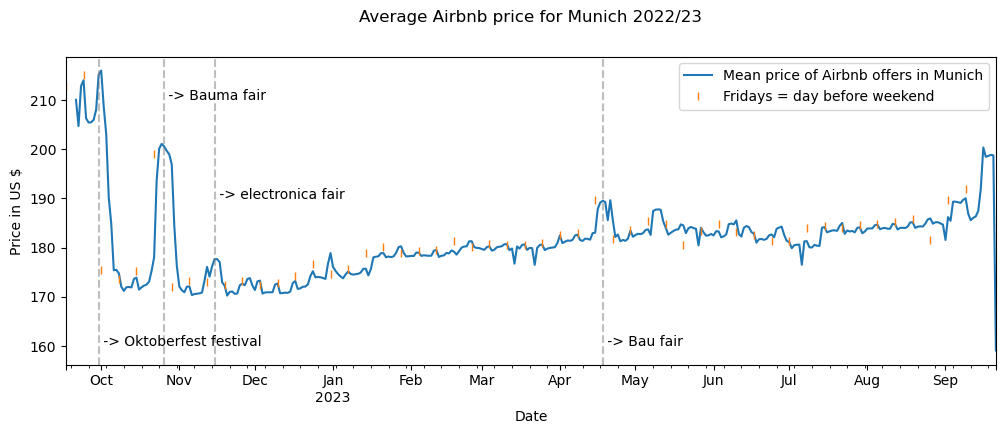

In [88]:
#plotting by groupby see also https://pandas.pydata.org/docs/getting_started/intro_tutorials/09_timeseries.html?highlight=datetime
fig, axs = plt.subplots(figsize=(12, 4))
ymin, ymax = plt.ylim()
df_calmuc.groupby(df_calmuc["date"])["price"].mean().\
    plot(color='tab:blue', label='Mean price of Airbnb offers in Munich')
df_weekend.groupby(df_weekend["date"])["price"].mean().\
    plot(marker='|', linewidth=0, markeredgecolor = 'tab:orange', markerfacecolor='tab:orange',\
    label='Fridays = day before weekend')
# custom labels for the axis
plt.xlabel("Date");  
plt.ylabel("Price in US $")
date_oktoberfest_22 = pd.Timestamp('2022-09-30')
date_electronica_22 = pd.Timestamp('2022-11-15')
date_oktoberfest_23 = pd.Timestamp('2022-10-25')
date_bauma_22 = pd.Timestamp('2022-10-26')
date_bau_23 = pd.Timestamp('2023-04-18')
#plot vertical lines for special events, see https://stackoverflow.com/questions/34742748/matplotlib-plot-date-add-vertical-line-at-specified-date
#and put a describtion beside the lines
plt.axvline(date_bau_23, 0, ymax, linestyle='--', color='tab:gray', alpha=0.5)
plt.text(x=date_bau_23, y = 160, s=' -> Bau fair')
plt.axvline(date_electronica_22, 0, ymax, linestyle='--', color='tab:gray', alpha=0.5)
plt.text(x=date_electronica_22, y = 190, s=' -> electronica fair')
plt.axvline(date_oktoberfest_22, 0, ymax, linestyle='--', color='tab:gray', alpha=0.5)
plt.text(x=date_oktoberfest_22, y = 160, s=' -> Oktoberfest festival')
plt.axvline(date_bauma_22, 0, ymax, linestyle='--', color='tab:gray', alpha=0.5)
plt.text(x=date_bauma_22, y = 210, s=' -> Bauma fair')
plt.title('Average Airbnb price for Munich 2022/23', pad=25)
#draw the legend in thwe upper right corner
plt.legend(loc='upper right');

For answering question 2 the neighborhood index of the listing dataset is grouped and the mean price for each neighborhood plotted

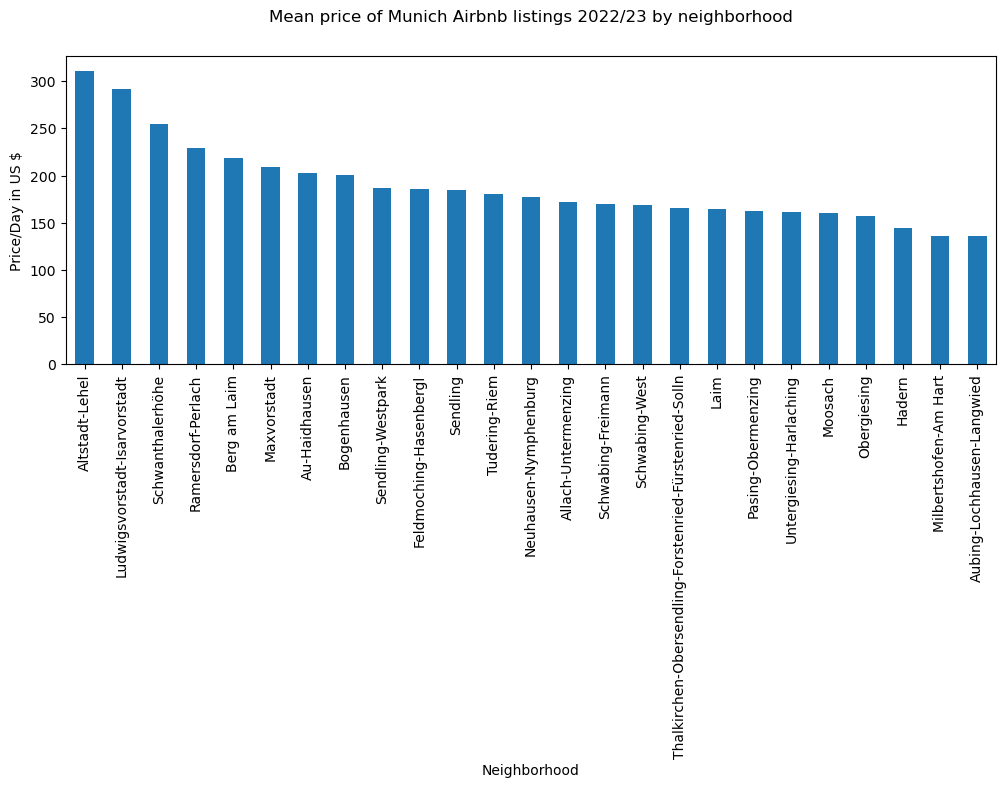

In [89]:
plt.rcParams["figure.figsize"] = (12,4)
df_price_by_neighbourhood = df_listmuc_int.groupby(['neighbourhood_cleansed'])[['price']].mean().sort_values(by='price',ascending=False)
df_price_by_neighbourhood.plot(kind='bar', legend = False)
plt.xlabel("Neighborhood");  
plt.ylabel("Price/Day in US $")
plt.title('Mean price of Munich Airbnb listings 2022/23 by neighborhood', pad = 25)
plt.xticks(rotation=90);

Question 3: Can the listing price be predicted based on certain characteristics?

In [90]:
#merge the listing and the calendar dataset
df_new = pd.merge(df_listmuc_int, df_calmuc, how='left', left_on='id', right_on='listing_id')
#delete not needed index and rename
df_new = df_new.drop(['price_x', 'minimum_nights_x','maximum_nights_x','listing_id','available','adjusted_price','date','weekday_num','id'], axis=1)
df_new = df_new.rename({'price_y': 'price', 'minimum_nights_y' : 'minimum_nights', 'maximum_nights_y': 'maximum_nights'}, axis=1)

In [91]:
#Split into explanatory and response variables
X = df_new.drop('price', axis=1)
y = df_new['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [92]:
#create dummy variables for categorical indexand scale the numerical columns

num_df = X.select_dtypes(include=['float','int'])
cat_df = X.select_dtypes(include='object')  
categorical_index= cat_df.columns
numerical_columns= num_df.columns

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    (StandardScaler(), numerical_columns),
)

In [93]:
#set up the model for a Ridge Regressor

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)


In [94]:
#fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  Index(['neighbourhood_cleansed', 'host_response_time', 'room_type', 'month',
       'weekday'],
      dtype='object')),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  Index(['host_response_rate', 'host_acceptance_rate', 'accommodates',
       'bathrooms', 'bedrooms', 'beds',...
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'minimum_nights', 'maximum_nights'],
      dtype='object'))])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=Ridge(alpha=1e-10)))])

In [95]:
#model evaluation
print('The R squared of the training set with Ridge regression for the best alpha is:', round(model.score(X_train, y_train), 2))
print('The R squared of the test set with Ridge regression for the best alpha is', round(model.score(X_test, y_test), 2))
print('The MSE is',mean_squared_error(y_test, model.predict(X_test)) )

The R squared of the training set with Ridge regression for the best alpha is: 0.14
The R squared of the test set with Ridge regression for the best alpha is 0.13
The MSE is 54851.21785277584


In [96]:
#check the performance of the computed model plotting its predictions on the test set and computing the median absolute error of the model.
from sklearn.metrics import median_absolute_error
from sklearn.metrics import PredictionErrorDisplay
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $",
    "MedAE on testing set": f"{mae_test:.2f} $",
}

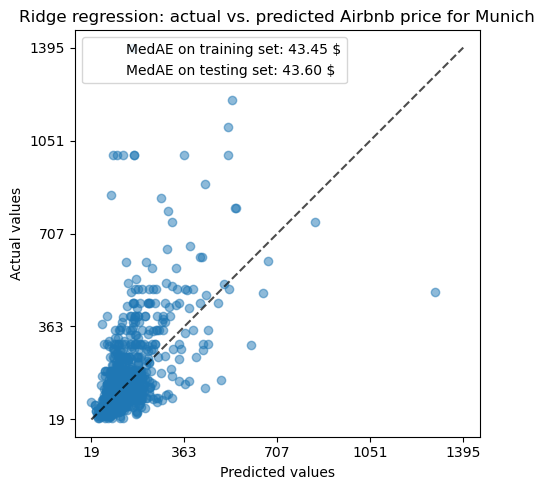

In [97]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge regression: actual vs. predicted Airbnb price for Munich")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

The model learnt is far from being a good model making accurate predictions: this is obvious when looking at the plot above, where good predictions should lie on the black dashed line.

Interpreting the coefficients

In [98]:
#get the name of the features
feature_names = model[:-1].get_feature_names_out()

In [99]:
X_train_preprocessed = pd.DataFrame(
    model[:-1].transform(X_train), columns=feature_names
)

coefs = pd.DataFrame(
    model[-1].regressor_.coef_ * X_train_preprocessed.std(axis=0),
    columns=["Coefficient importance"],
    index=feature_names,
)

In [100]:
#format strings for filter
coefs.index = coefs.index.str.replace('onehotencoder__','')
coefs.index = coefs.index.str.replace('standardscaler__','')
coefs.index = coefs.index.str.replace('Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln','Thalk./Obers./Forstenr./Fürstenr./Solln')
d = {'bedrooms':'other_bedrooms','beds':'other_beds','bathrooms':'other_bathroooms','accommodates':'other_accommodates'}
for key,value in d.items():
    coefs.index = coefs.index.str.replace(key,value)
#set filter lists
keyword_list =('neighbourhood_cleansed_','room_type_','host_','month_','weekday_','other_','review_','nights')
subplot_title_list = ('Neighbourhood', 'Room Type','Host','Month','Weekday','Others','Reviews','Booking Period')

In [101]:
def create_filter_df(key):
    df = coefs.filter(like = key,axis=0).sort_values(by='Coefficient importance', ascending=True)
    if (key != 'nights') and (key != 'review'): df.index = df.index.str.replace(key,'')
    if (key == 'neighbourhood_cleansed_'): df.index = df.index.str.replace('-',' ')
    df.index = df.index.str.replace('_',' ')
    df.index = df.index.str.title()
    return df

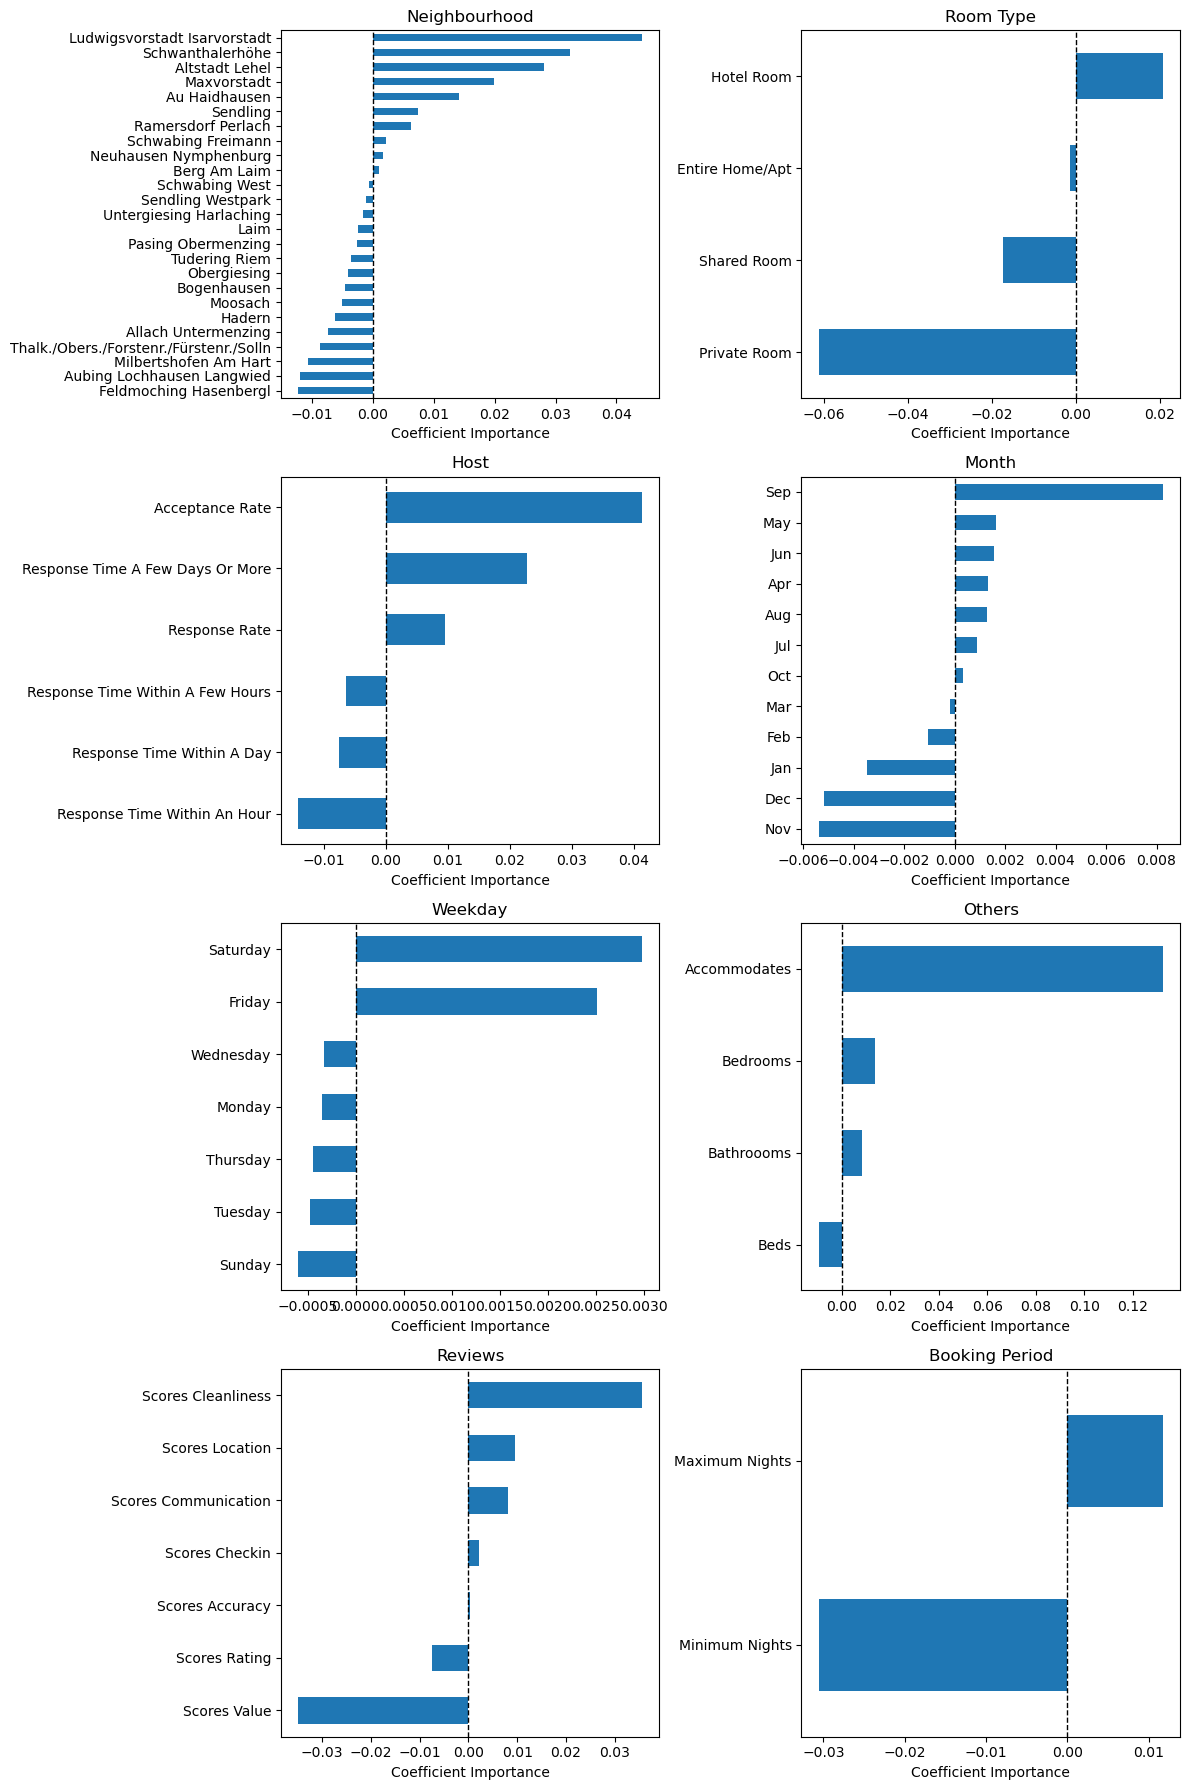

In [102]:
#define the subplots 
#fig, axs = plt.subplots(4, 2, figsize=(14, 8), dpi=100, gridspec_kw = {'height_ratios': [4, 2]})
x_count = 2
y_count = 4
max = coefs['Coefficient importance'].max()
fig, axs = plt.subplots(y_count, x_count, figsize=(12, 18), constrained_layout=True)
#create a list of the subplot positions
position_list = []
for a in range(y_count):
    for b in range(x_count):
        position_list.append(axs[a,b])
for key, title, pos in zip(keyword_list, subplot_title_list, position_list,):
    plot_df = create_filter_df(key)
    #plot the data in a subplot
    plot_df.plot(kind='barh',ax=pos,title=title,legend=None)
    pos.axvline(x=0,linewidth=1, color='k', linestyle="--")
    #set title and label of the x and y axis
    pos.set_title(title)
    pos.set_xlabel('Coefficient Importance')
    pos.set_ylabel('') #no label for the y axis
fig.tight_layout()
plt.show();
    


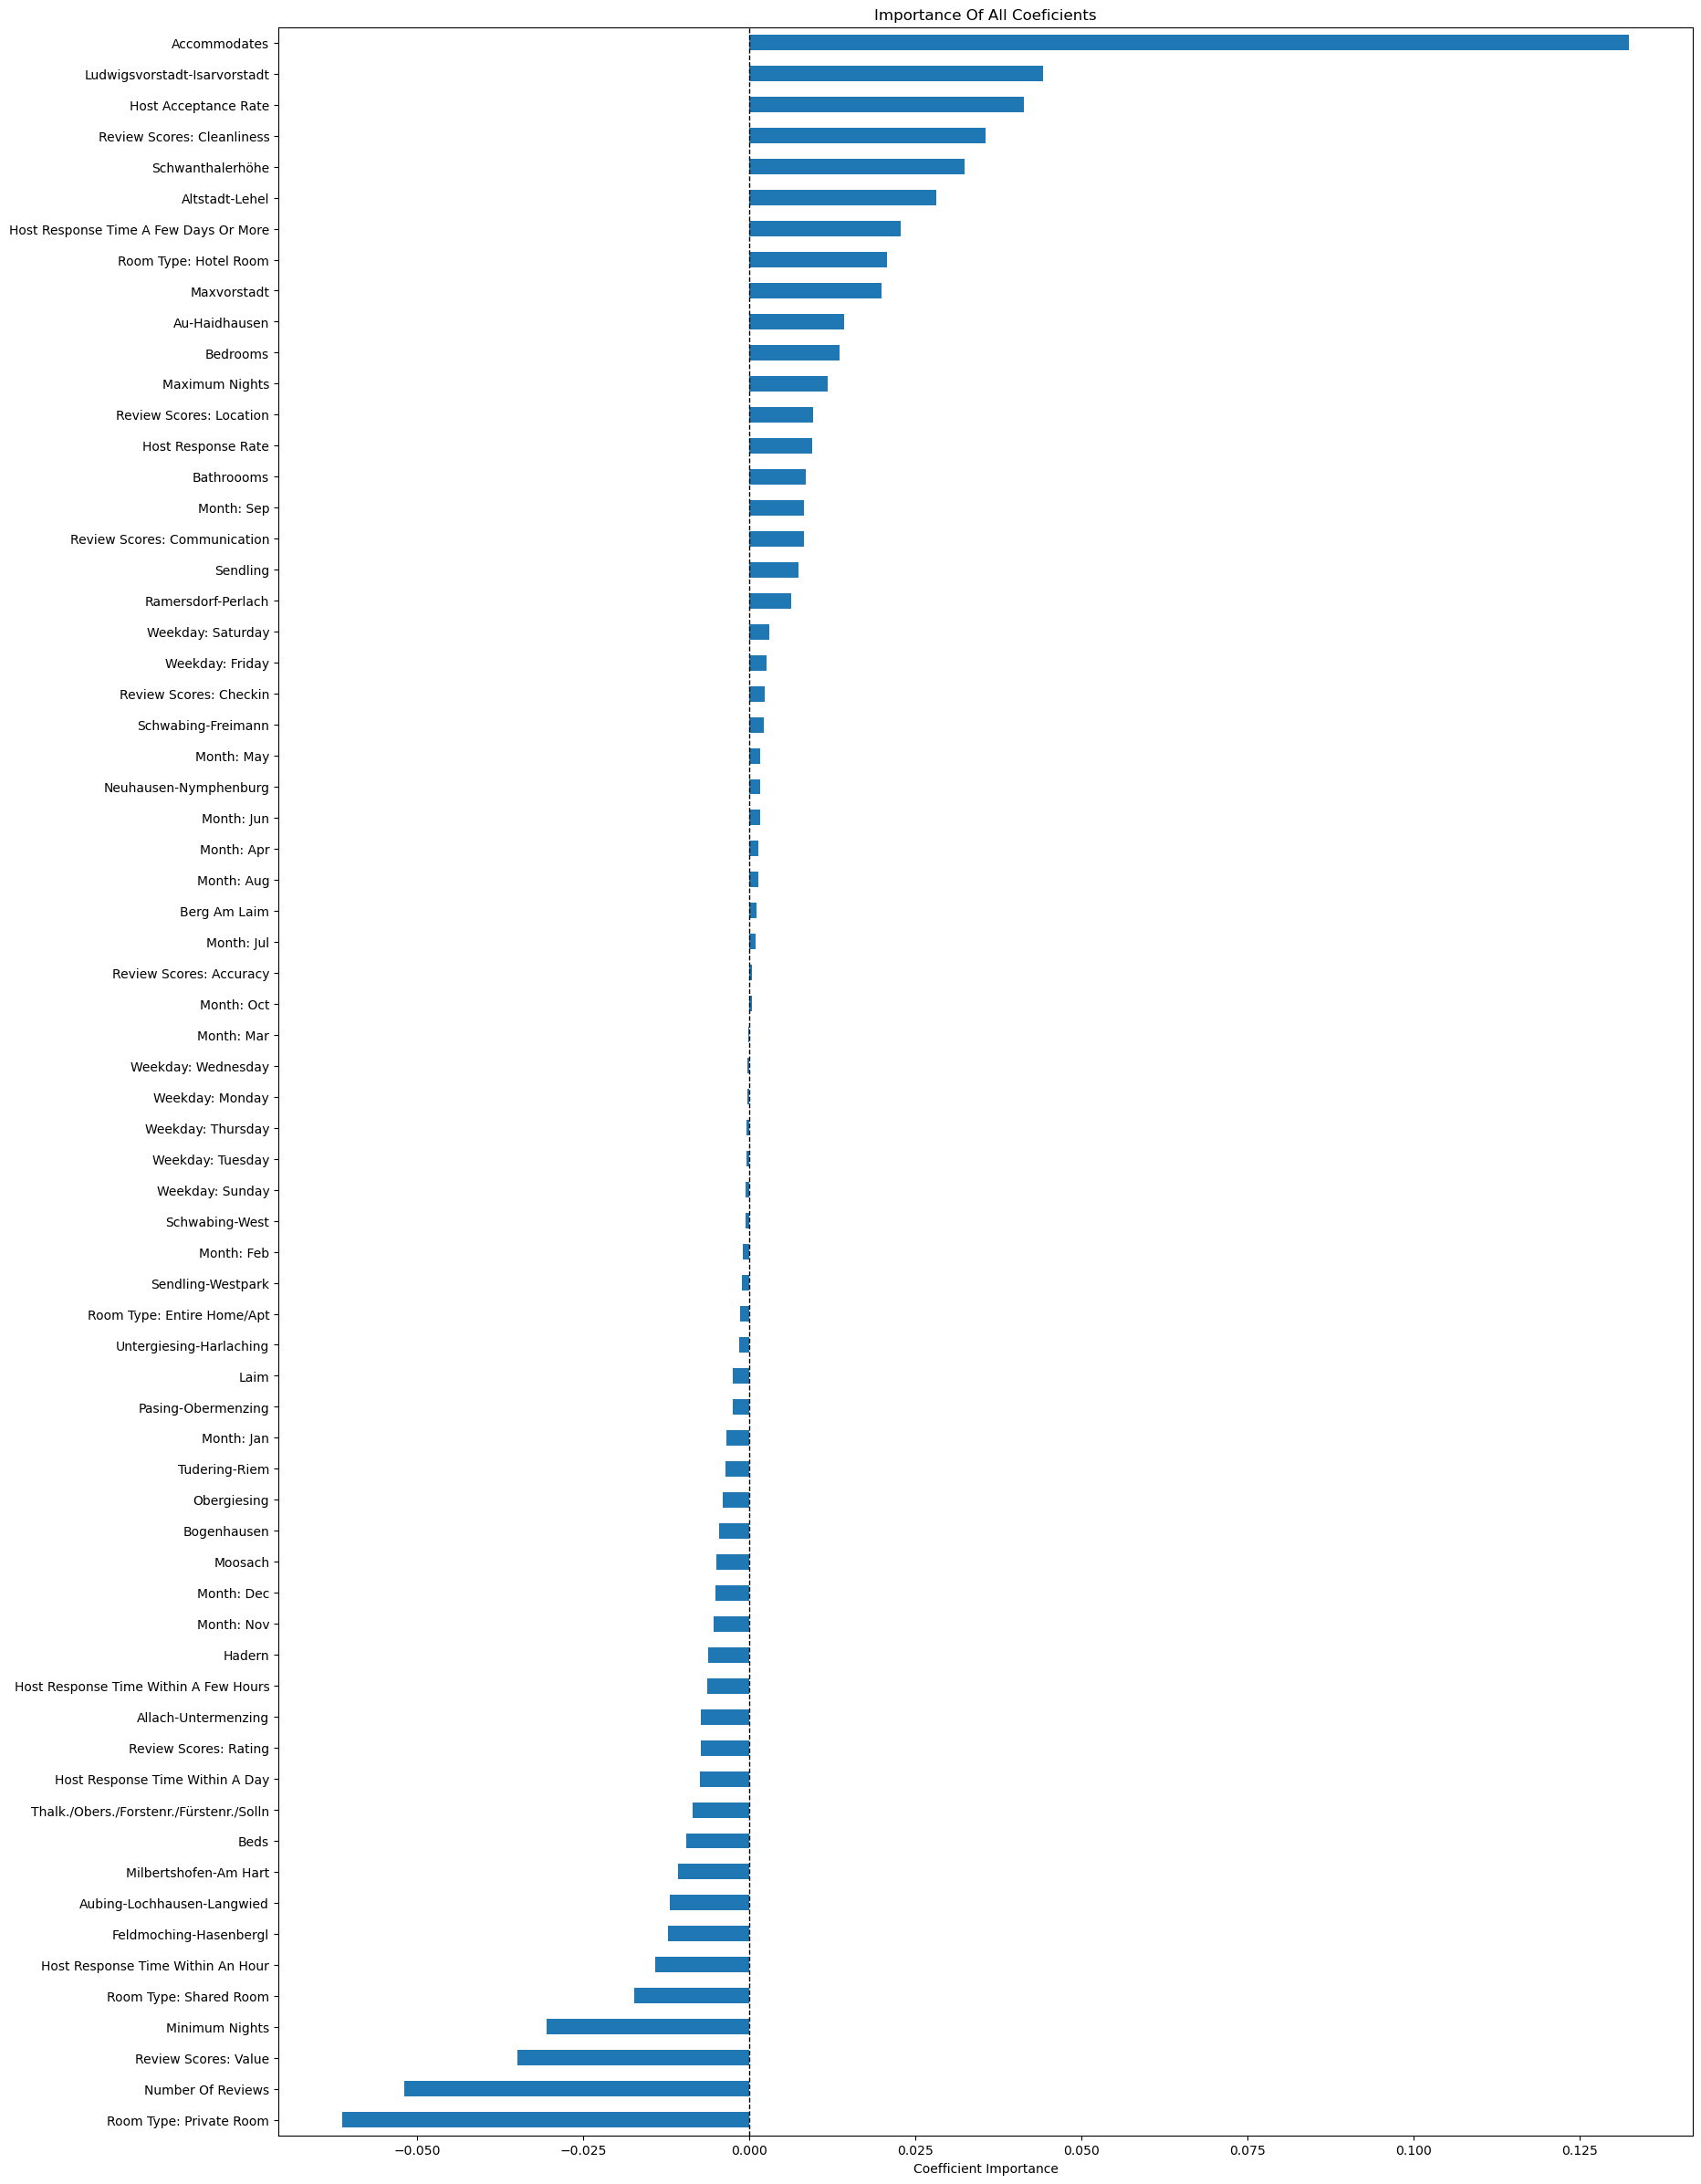

In [114]:
coefs_all = coefs.copy()
coefs_all.index= coefs_all.index.str.replace('neighbourhood_cleansed_','')
coefs_all.index= coefs_all.index.str.replace('month_','Month: ')
coefs_all.index= coefs_all.index.str.replace('review_scores_','Review Scores: ')
coefs_all.index= coefs_all.index.str.replace('other_','')
coefs_all.index= coefs_all.index.str.replace('weekday_','Weekday: ')
coefs_all.index= coefs_all.index.str.replace('room_type_','Room Type: ')
coefs_all.index= coefs_all.index.str.replace('_',' ')
coefs_all.index= coefs_all.index.str.title()
coefs_all = coefs_all.sort_values(by='Coefficient importance', ascending=True)
coefs_all.plot(kind='barh', figsize = (20,30),legend = None)
plt.axvline(x=0,linewidth=1, color='k', linestyle="--")
plt.title('Importance Of All Coeficients')
plt.xlabel('Coefficient Importance')
plt.show();

In [123]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)

coefs2 = pd.DataFrame(
    [
        est[-1].regressor_.coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))
    ],
    columns=feature_names,
);

/Users/Tiger/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.64817e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [124]:
coefs2.index= coefs2.columns.str.replace('onehotencoder__','')
coefs2.columns= coefs2.columns.str.replace('standardscaler__','')
coefs2.index= coefs2.columns.str.replace('neighbourhood_cleansed_','')
coefs2.index= coefs2.columns.str.replace('month_','Month: ')
coefs2.index= coefs2.columns.str.replace('weekday_','Weekday: ')
coefs2.index= coefs2.columns.str.replace('room_type_','Room Type: ')
coefs2.columns = coefs2.columns.str.replace('_',' ')
coefs.columns = coefs.columns.str.replace('Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln','Thalk./Obers./Forstenr./Fürstenr./Solln')
coefs2.columns = coefs2.columns.str.title()


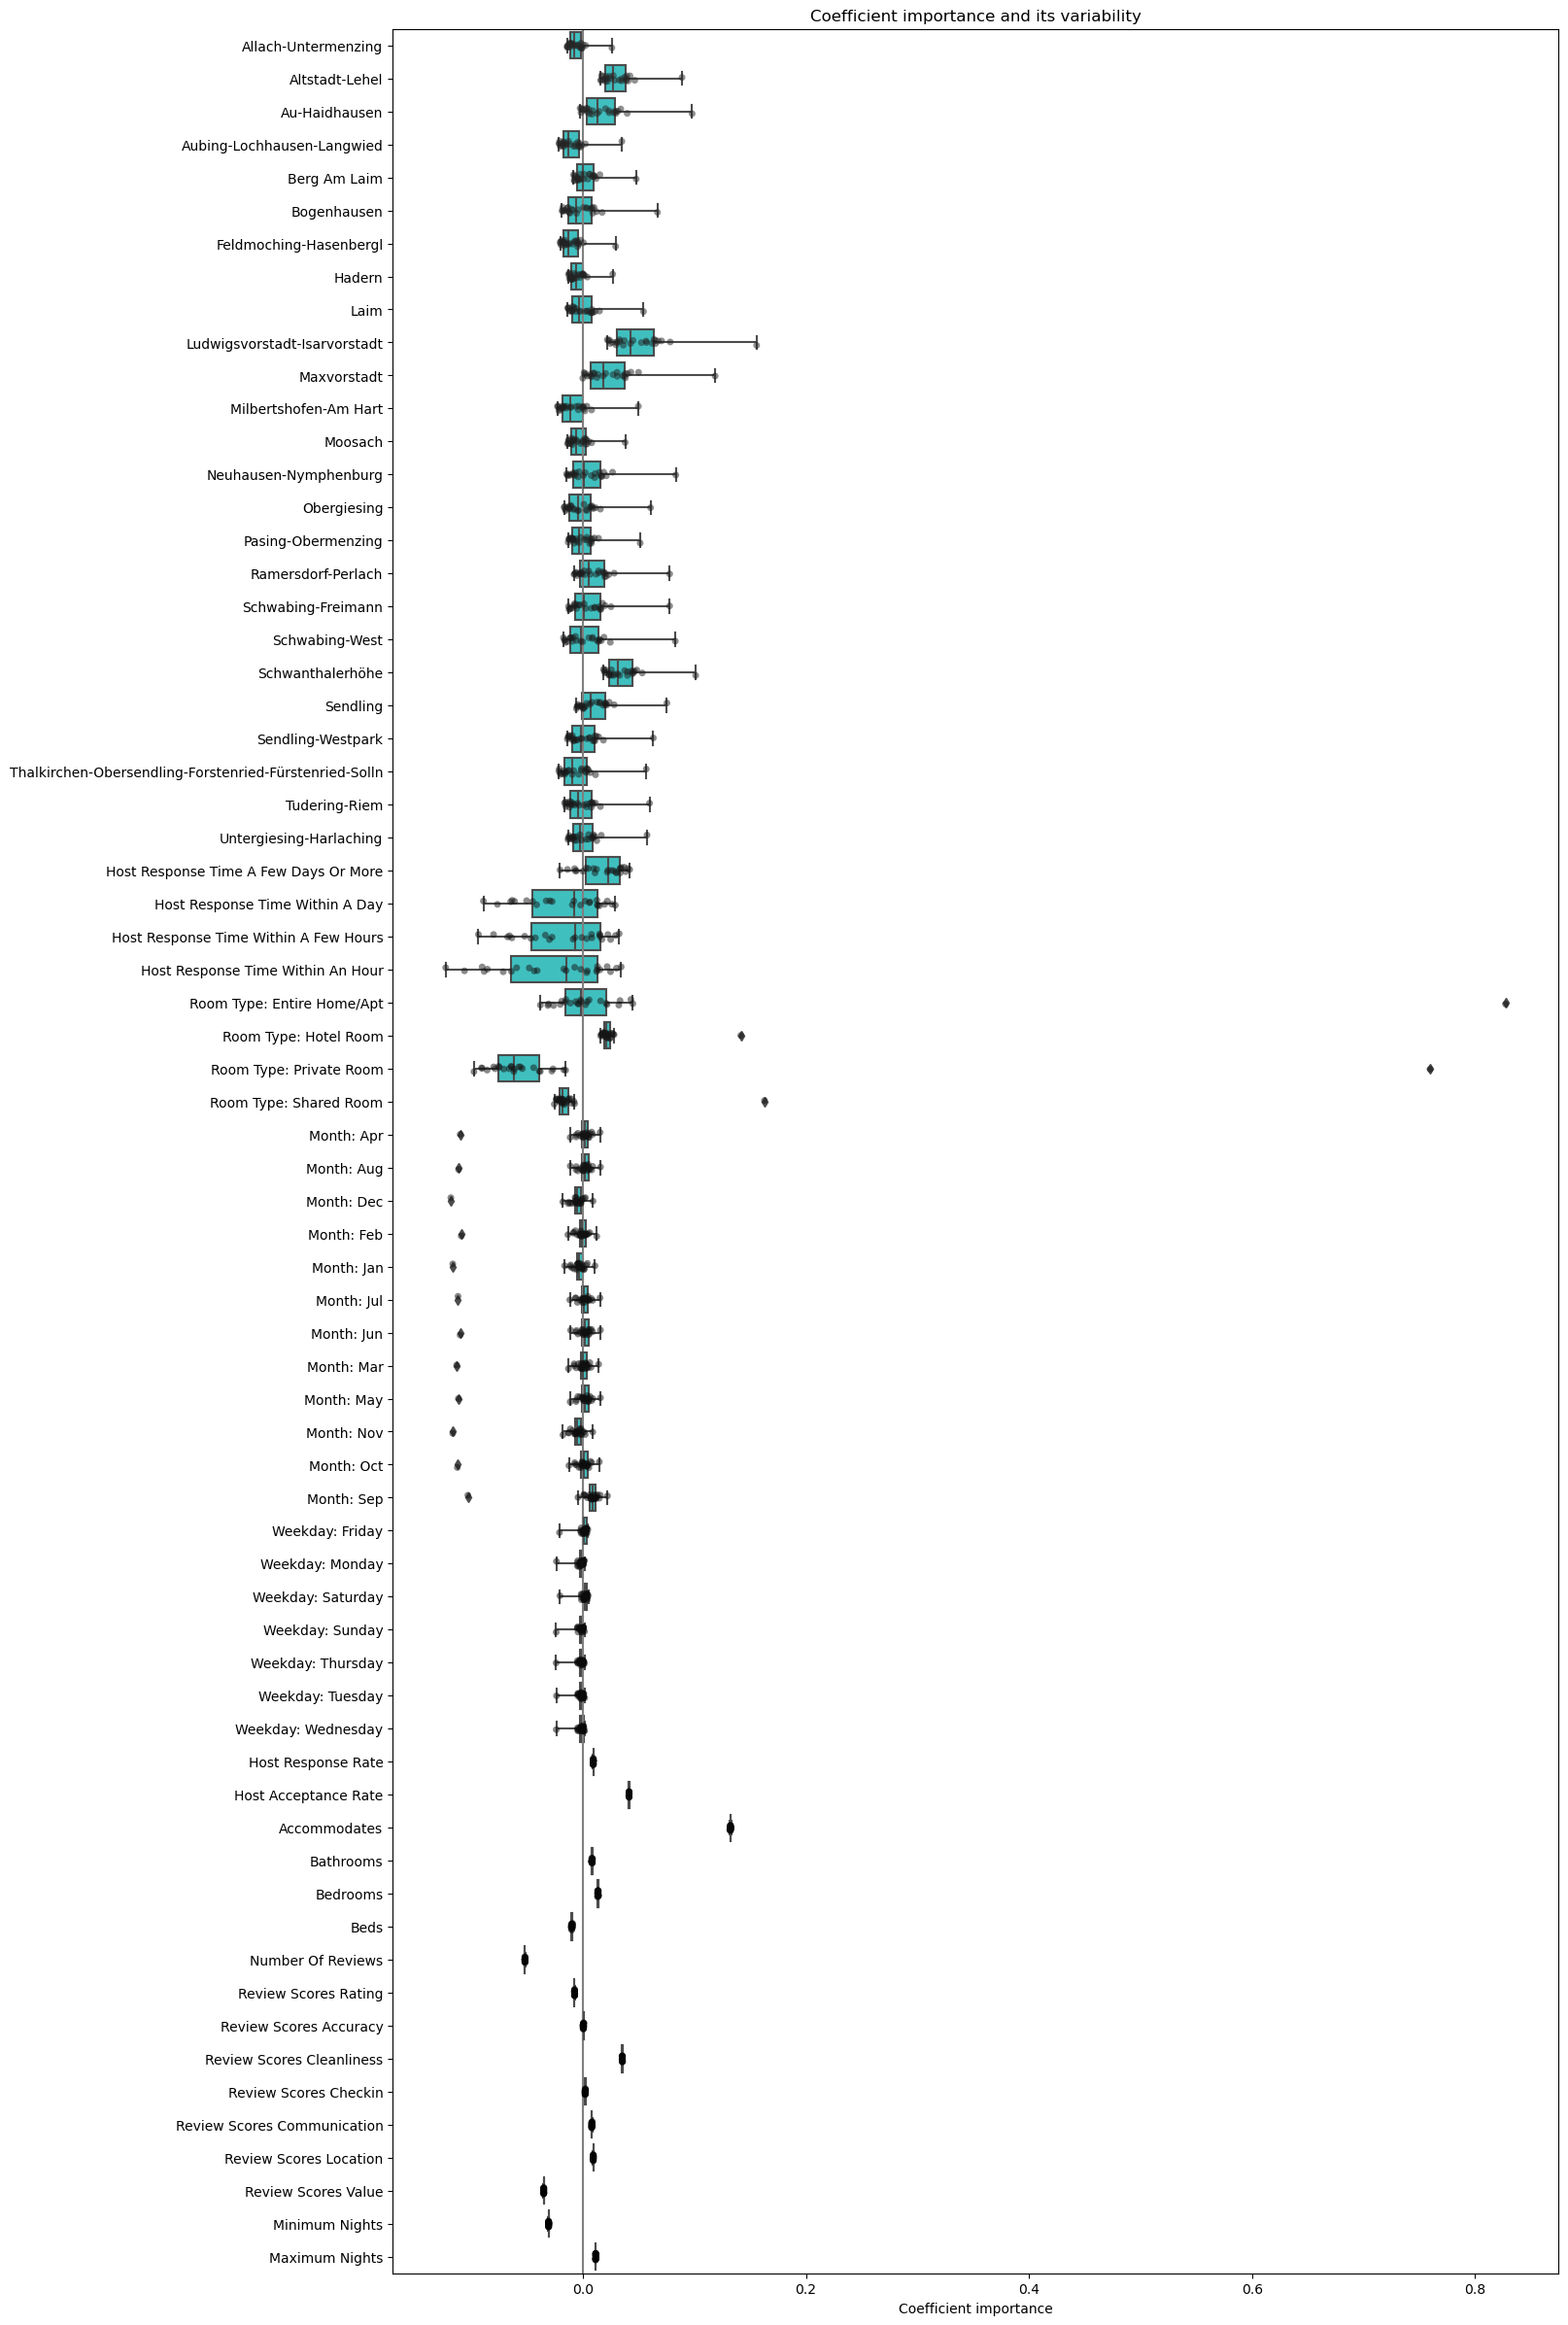

In [125]:
plt.figure(figsize=(20, 30))
sns.stripplot(data=coefs2, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs2, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

### Conclusions:

A linear model leads only to an insufficient prediction quality. In particular, the strong sensitivity of the price to events such as trade fairs and the Oktoberfest seems difficult to model with a linear model. Furthermore, the high variability of many coefficients is striking. In a next step, the individual coefficients could be checked for mutual dependencies and reduced if necessary, and a nonlinear model could be tested for better suitability with respect to prediction accuracy.